In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob
import matplotlib
sns.set_palette('colorblind',10)
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=25) 
matplotlib.rc('ytick', labelsize=25)
matplotlib.rc('axes',labelsize=25) 
from astropy.table import Table
import os
__outdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/Output/'
__datdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/data/KepxDR2/'

In [2]:
def read_data():
    '''Reads in the Yu et al. 2018 data'''
    sfile = __datdir__+'rcxyu18.csv'
    df = pd.read_csv(sfile)
    return df

In [3]:
from scipy.optimize import curve_fit
def f(x, A, B):
    return A*x + B

def get_slopes(mls, ccd=1, vals=False):
    y = np.array([])
    x = np.array([])
    yerr = np.array([])
    xerr = np.array([])

    for ml in mls:
        for ts in np.arange(-50.,100.,50.):
            try:
                temp = str(ts)
                pars = pd.read_csv(__outdir__+ml+'/'+'gaia_'+temp+'_ccd_'+str(ccd)+'_pars.csv')
                y = np.append(y, pars['oo_zp'])
                x = np.append(x, pars['mu'])
                yerr = np.append(yerr, pars['oo_zp_std'])
                xerr = np.append(xerr, pars['mu_std'])
            except IOError:
                pass

    popt, pcov = curve_fit(f, x, y, sigma=yerr)
    print('oozp = '+str(np.round(popt[0],5))+'*mu + '+str(np.round(popt[1],5)))
    print('mu = '+str(np.round(1./popt[0], 5))+'*oozp - '+str(np.round(popt[1]/popt[0],5)))
    
   
    if vals:
        return x, y, xerr, yerr

    return popt

In [7]:
def read_music(mls):
    chains = np.array([])
    tempscales = np.array([])
    rcmag = np.array([])
    source = np.array([])
    sources = ['Yu+2018','APOKASC-2']
    cols = ['Left','Right']
    col = np.array([])
        
    for idx, ml in enumerate(mls):
        for ts in np.arange(-50.,100.,50.):
            temp = str(ts)

            #Add RC chains & labels
            try:
                chain = np.genfromtxt(__outdir__+ml+'/'+'gaia_'+temp+'_chains.txt')[-1]
                chains = np.append(chains, chain)
                tempscales = np.append(tempscales, np.ones(len(chain))*ts)

                mu = np.round(pd.read_csv(__outdir__+ml+'/'+'gaia_'+temp+'_pars.csv')['mu'].values[0],2)
                rcmag = np.append(rcmag, np.ones(len(chain))*mu)
                
                source = np.append(source, [sources[idx]]*len(chain))
                col = np.append(col, [cols[idx]]*len(chain))
                
            except IOError:
                popt = get_slopes(mls, ccd)
                mu_wanted = np.round(pd.read_csv(__outdir__+ml.replace('Gaia_','')+'/'+'astero_'+temp+'_pars.csv')['mu'].values[0],2)
                oozp_wanted = popt[0]*mu_wanted + popt[1]
                oozp_base = pd.read_csv(__outdir__+mls[0]+'/'+'gaia_-50.0_pars.csv')['oo_zp'].values[0]
                diff = oozp_wanted - oozp_base
                chain = np.genfromtxt(__outdir__+mls[0]+'/'+'gaia_-50.0_chains.txt')[-1]
                
                chains = np.append(chains, chain+diff)
                rcmag = np.append(rcmag, np.ones(len(chain))*mu_wanted)
                source = np.append(source, ['Extrapolated']*len(chain))
                tempscales = np.append(tempscales, np.ones(len(chain))*ts)
                col = np.append(col, [cols[idx]]*len(chain))

                

    music = pd.DataFrame()
    music['chains'] = chains
    music['tempscales'] = tempscales
    music['rcmag'] = rcmag
    music['source'] = source
    music['col'] = col

    return music

In [26]:
def violinplot(mlk, mlg, save=''):
    kmusic = read_music(mlk)
    gmusic = read_music(mlg)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8), sharey=True)
    sns.violinplot(kmusic.rcmag.values, kmusic.chains.values,
                        palette='Set2', hue = kmusic.source.values, dodge=False, inner='quartile', ax = ax1)
    sns.violinplot(gmusic.rcmag.values, gmusic.chains.values,
                        palette='Set2', hue = gmusic.source.values, dodge=False, inner='quartile', ax = ax2)
    ax1.grid()
    
    ax1.set_axisbelow(True)
    ax2.grid()
    ax2.set_axisbelow(True)  
    ax1.set(xlabel=r'Position of RC in $K$-band (mag)', ylabel=r'Parallax Zero-Point Offset $\varpi_{\rm zp}$ (pc)')
    ax1.set_title('K band',fontsize=25)
    ax2.set(xlabel=r'Position of RC in $G$-band (mag)')
    ax2.set_title(r'$\emph{Gaia}$ G band',fontsize=25)    
    plt.setp(ax1.get_legend().get_texts(), fontsize='25')
    plt.setp(ax2.get_legend().get_texts(), fontsize='25')
    fig.tight_layout()
    
    if save is not '':
        plt.savefig(save)
    plt.show()

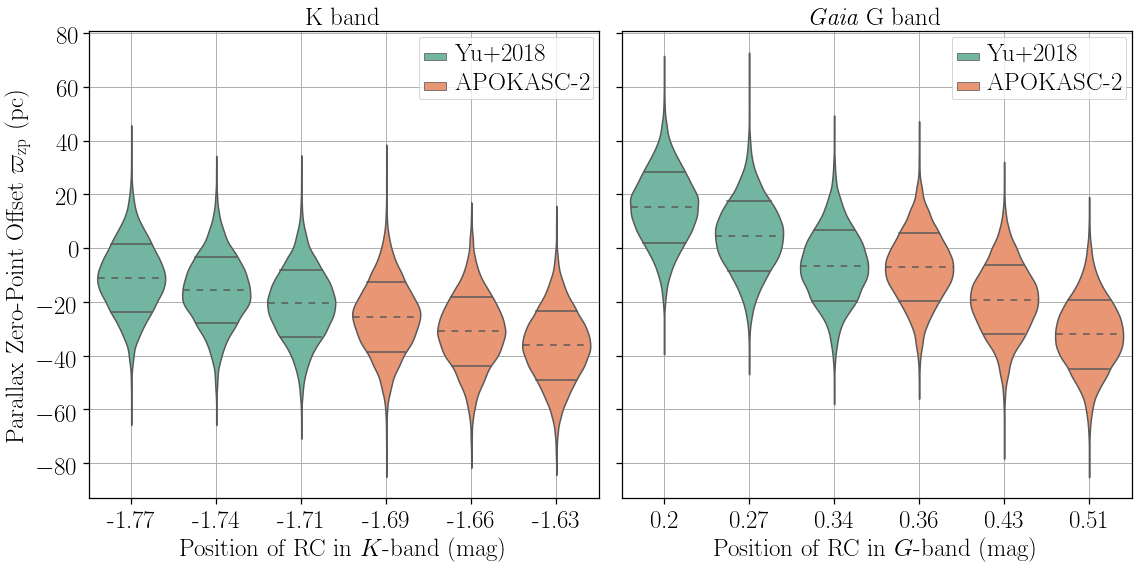

In [27]:
# mlk = ['Organiser/Pre-final/Gaia_K_tempscale_Clump', 'Gaia_APOKASC_K_tempscale_Clump']
mlk = ['Gaia_K_tempscale_Clump', 'Gaia_APOKASC_K_tempscale_Clump']
mlg = ['Gaia_GAIA_tempscale_Clump', 'Gaia_APOKASC_GAIA_tempscale_Clump']
violinplot(mlk, mlg)

In [58]:
def violinplot_new(mlk, mlg, save=''):
    kmusic = read_music(mlk)
    gmusic = read_music(mlg)
        
    import matplotlib.gridspec as gridspec
    fig = plt.figure(figsize=(16, 8))
    gs0 = gridspec.GridSpec(1, 2, figure=fig)
    gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0], wspace=0.)
    gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[1], wspace=0.)

    ax1 = plt.subplot(gs1[:, :1])
    ax2 = plt.subplot(gs1[:, 1:],sharey=ax1)
    ax3 = plt.subplot(gs2[:, :1],sharey=ax1)
    ax4 = plt.subplot(gs2[:, 1:],sharey=ax1)
    
    sel = np.where(kmusic.source == 'Yu+2018')
    sns.violinplot(kmusic.rcmag[sel].values, kmusic.chains[sel].values,
                        palette='Set2', hue = kmusic.source[sel].values, dodge=False, inner='quartile', ax = ax1)
    sel = np.where(kmusic.source == 'APOKASC-2')
    sns.violinplot(kmusic.rcmag[sel].values, kmusic.chains[sel].values,
                        palette='Set2', hue = kmusic.source[sel].values, dodge=False, inner='quartile', ax = ax2)
    
    sel = np.where(kmusic.source == 'Yu+2018')    
    sns.violinplot(gmusic.rcmag[sel].values, gmusic.chains[sel].values,
                        palette='Set2', hue = gmusic.source[sel].values, dodge=False, inner='quartile', ax = ax3)
    sel = np.where(kmusic.source == 'APOKASC-2')
    sns.violinplot(gmusic.rcmag[sel].values, gmusic.chains[sel].values,
                        palette='Set2', hue = gmusic.source[sel].values, dodge=False, inner='quartile', ax = ax4)
    
    ax1.grid()
    ax1.set_axisbelow(True)
    ax2.grid()
    ax2.set_axisbelow(True)  

    ax1.set(xlabel=r'Position of RC in $K$-band (mag)', ylabel=r'Parallax Zero-Point Offset $\varpi_{\rm zp}$ (pc)')
    ax1.set_title('K band',fontsize=25)
    ax2.set(xlabel=r'Position of RC in $G$-band (mag)')
    ax2.set_title(r'$\emph{Gaia}$ G band',fontsize=25)    
    plt.setp(ax1.get_legend().get_texts(), fontsize='25')
    plt.setp(ax2.get_legend().get_texts(), fontsize='25')
    fig.tight_layout()
    
    if save is not '':
        plt.savefig(save)
    plt.show()

ValueError: Can only tuple-index with a MultiIndex

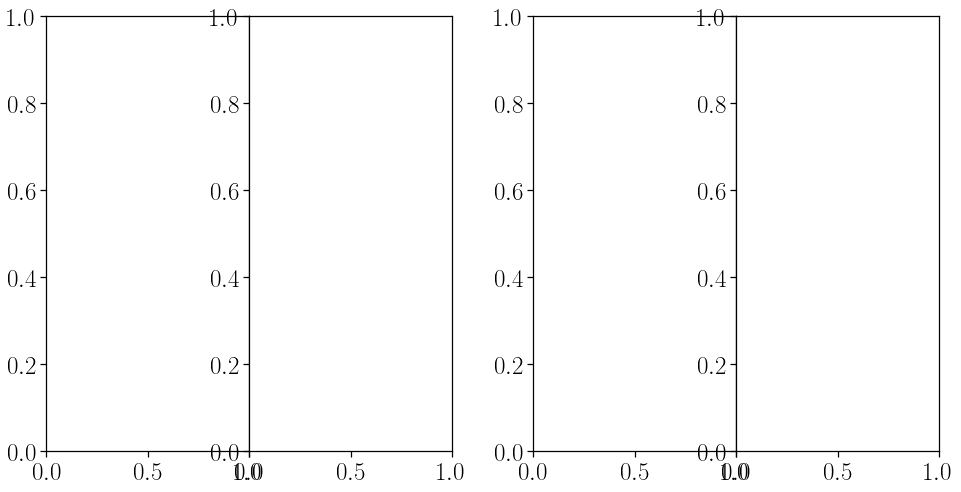

In [59]:
mlk = ['Gaia_K_tempscale_Clump', 'Gaia_APOKASC_K_tempscale_Clump']
mlg = ['Gaia_GAIA_tempscale_Clump', 'Gaia_APOKASC_GAIA_tempscale_Clump']
violinplot_new(mlk, mlg)

In [55]:
    kmusic = read_music(mlk)
    gmusic = read_music(mlg)

In [57]:
kmusic.shape

(60000, 5)

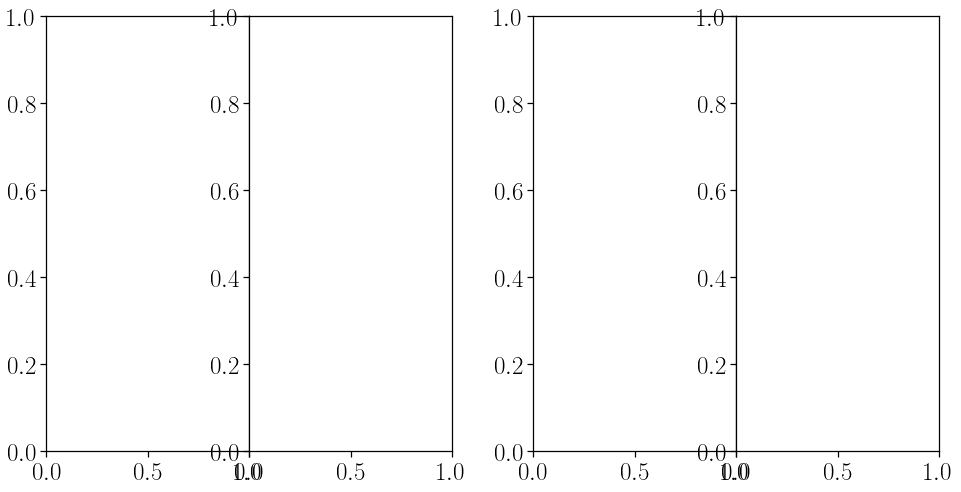

In [52]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(16, 8))
gs0 = gridspec.GridSpec(1, 2, figure=fig)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0], wspace=0.)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[1], wspace=0.)

ax1 = plt.subplot(gs1[:, :1])
ax2 = plt.subplot(gs1[:, 1:],sharey=ax1)
ax3 = plt.subplot(gs2[:, :1],sharey=ax1)
ax4 = plt.subplot(gs2[:, 1:],sharey=ax1)

plt.show()

In [12]:
def calc_oozp(mrc, band):
    if band == 'K':
        out = -181.17332*mrc + -333.06359
    if band == 'G':
        out = -159.32172*mrc + 43.56603
    print(out)
def calc_mrc(oozp, band):
    if band == 'K':
        out = -0.00552*oozp - 1.83837
    if band == 'G':
        out = -0.00628*oozp - -0.27345
    print(out)    
print('Lindegren')
calc_mrc(-28, 'K')
calc_mrc(-28, 'G')
print('Silva Aguirre')
calc_mrc(-35, 'K')
calc_mrc(-35, 'G')
print('Riess')
calc_mrc(-46, 'K')
calc_mrc(-46, 'G')
print('Zinn')
calc_mrc(-52.8, 'K')
calc_mrc(-52.8, 'G')
print('\n')

print('Girardi median')
calc_oozp(-1.585, 'K')
print('Hawkins K')
calc_oozp(-1.61, 'K')
print('This Work (K, RC, Yu)')
calc_oozp(-1.742, 'K')
print('This Work, (K, RC, AK2)')
calc_oozp(-1.660, 'K')

print('Hawkins G')
calc_oozp(0.44, 'G')
print('This Work, (G, RC, Yu)')
calc_oozp(0.268, 'G')
print('This Work, (G, RC, AK2)')
calc_oozp(0.429, 'G')



Lindegren
-1.68381
0.44929
Silva Aguirre
-1.64517
0.49325
Riess
-1.58445
0.56233
Zinn
-1.546914
0.605034


Girardi median
-45.9038778
Hawkins K
-41.3745448
This Work (K, RC, Yu)
-17.45966656
This Work, (K, RC, AK2)
-32.3158788
Hawkins G
-26.5355268
This Work, (G, RC, Yu)
0.86780904
This Work, (G, RC, AK2)
-24.78298788
